# KERAS and TENSORFLOW
We start by importing all the necessary packages
(%lsmagic for magic commanda and ! for bash instruction)

In [1]:
import sys;
import os, sys, array, re, math, random, subprocess, glob
from math import *
import numpy as np
import scipy
from numpy.lib.recfunctions import stack_arrays
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cPickle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Highway, MaxoutDense, Masking, GRU, Merge, Input, merge
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
import deepdish.io as io
import ROOT
from ROOT import gSystem, gROOT, gApplication, TFile, TTree, TCut, TH1F, TCanvas
from root_numpy import root2array, root2array 
print "I you had no error so far, this is great! We can start the tutorial."

Using Theano backend.


Welcome to JupyROOT 6.08/06
I you had no error so far, this is great! We can start the tutorial.

/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.08/06 is currently active but you installed root_numpy against ROOT 6.08/00. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/Users/Luca2/Library/Python/2.7/lib/python/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.11.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


We set some variables we will use later

In [2]:
# Check this file out, it contains many functions we will use.
execfile("Useful_func.py")
# Fix random seed for reproducibility
seed = 7; np.random.seed(seed);
isDelphes = False # i.e. using delphes sample or cmssw ones 
# Input paramters
debug = True #(Verbose output)
folder='Plots_hh_tt_MLP/' # Folder with Plots
MakePlots=False # Set False if you want to run faster
folderCreation  = subprocess.Popen(['mkdir -p ' + folder], stdout=subprocess.PIPE, shell=True); folderCreation.communicate()
folderCreation2 = subprocess.Popen(['mkdir -p models/'], stdout=subprocess.PIPE, shell=True); folderCreation2.communicate()

# Pre-selection and branches to include

('', None)

Now We Start manipulating ROOT files into a format we can use to train a MVA

In [3]:
# Our goal is to separate BX Signal from TT background. The machine learning only want to analyze "good events"
# We defoe god events by: 
# 1) Applying a preselection to out Signal and background events
my_selec = 'met_pt>20 && met_pt<500 && muon1_pt>20 && fabs(muon1_eta)<2.4 && muon2_pt>10 && fabs(muon2_eta)<2.4 && pt_l1l2<500 && pt_b1b2<500 && mass_l1l2>12 && mass_l1l2<500 && mass_b1b2<500 && b1jet_pt>20 && fabs(b1jet_eta)<2.4 && b2jet_pt>20 && fabs(b2jet_eta)<2.4 && mass_trans>10 && mass_trans<500 && HT<4000'
# 2) Selecting the branches that contains the information we want to use (in general)
my_branches = ["mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt","muon1_pogSF","muon2_pogSF","XsecBr"]
# 3) Selecting the branches that contains the information we want to use (in the training)
my_branches_training = ["mass_trans","dphi_llmet","dphi_llbb","eta_l1l2","pt_l1l2","mass_l1l2","eta_b1b2","pt_b1b2","mass_b1b2","dR_minbl","dR_l1l2b1b2","HT","met_pt"]
    
# Converting Root files in dataframe (Very useful, checnl root2panda in Useful_func.py)
if isDelphes:
    hh    = root2panda('files/delphes_B3_1M_PU40ALL_1Ag_mvammc_TRIMMED.root', 'evtree', branches=my_branches, selection=my_selec)
    ttbar = root2panda('files/delphes_tt_4M_PU40_WtomuALL_1Ag_mvammc_TRIMMED_5Kevents.root', 'evtree', branches=my_branches, selection=my_selec)
else:
    hh    = root2panda('files/MVA_GluGluToRadionToHHTo2B2VTo2L2Nu_M-500_narrow_13TeV-madgraph-v2.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
    ttbar  = root2panda('files/MVA_TTTo2L2Nu_13TeV-powheg.root', 'DiHiggsWWBBAna/evtree', branches=my_branches, selection=my_selec)
# Create a variable that is the total weight (weight=weight for xsec, reweighting=weight depending on muons)
if isDelphes:
    hh['fin_weight']    = hh['weight']*hh['reweighting']
    ttbar['fin_weight'] = ttbar['weight']*ttbar['reweighting']
else:
    hh['fin_weight']    = hh['XsecBr'] * hh['muon1_pogSF'] * hh['muon2_pogSF'] #1pb
    ttbar['fin_weight'] = ttbar['XsecBr'] * ttbar['muon1_pogSF'] * ttbar['muon2_pogSF'] #87pb
    ## Save the dataframe as h5 file (for quick loading in the future).
#io.save(open('models/ttbar.h5', 'wb'), ttbar)
#ttbar = io.load(open('models/ttbar.h5', 'rb'))

if debug:
  print("---> hh Displayed as panda dataframe: "); print(hh)
  print("The shape for hh is (nb_events, nb_variables): "); print(hh.shape)
  print("The shape for tt is (nb_events, nb_variables): "); print(ttbar.shape)

---> hh Displayed as panda dataframe: 
      mass_trans  dphi_llmet  dphi_llbb  eta_l1l2     pt_l1l2  mass_l1l2  \
0      72.777069   -0.886775   3.002455  0.922840   84.128227  29.190264   
1     159.240128   -1.983317   2.945254 -0.149637  105.026260  44.730267   
2     118.480865    1.224844  -1.547155 -1.470161  126.250465  24.067703   
3      43.424339    0.340652  -3.017415  1.175856  114.969040  41.966232   
4      33.620312    0.274080  -0.962814  1.154134   84.900856  63.884369   
5     127.793579    1.449566   2.705430  1.900905  166.623047  18.158842   
6      39.307190    0.292008  -2.213338 -0.131672  304.269775  36.601650   
7      11.351856    0.127380   2.885273  1.712558   92.330399  18.176708   
8      26.132015   -0.400537   2.394995  0.145146   72.556770  43.897713   
9      49.478588   -0.587437   2.266979 -0.363785   46.964069  52.886749   
10     96.429413   -1.294901   2.532745  1.689363   67.388756  12.660436   
11     84.855293   -0.696022   2.843185  0.058142

In [4]:
%matplotlib inline
# Plots of the branches we selected
if (MakePlots) :
  for key in ttbar.keys() :
      if(key!="muon1_pogSF" and key!="muon2_pogSF" and key!="XsecBr" and key!="fin_weight") :
        matplotlib.rcParams.update({'font.size': 16})
        fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
        bins = np.linspace(my_max(min(ttbar[key]),0.), max(ttbar[key]), 50)
        _ = plt.hist(hh[key],  bins=bins, histtype='step', normed=True, label=r'$hh$', linewidth=2)
        _ = plt.hist(ttbar[key], bins=bins, histtype='step', normed=True, label=r'$t\overline{t}$')
        plt.xlabel(key)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        print('Saving:',folder + '/' + str(key) + '.pdf')
        plt.savefig(folder + "/" + str(key) + '.pdf')

In [5]:
print('Now lets start to talk about DNN!')
# Not lets draw the correlations
c1 = ROOT.TCanvas(); c1.cd(); ROOT.gStyle.SetOptStat(0)
if MakePlots:
    h_Corr_hh    = ROOT.TH2F("h_Corr_hh","", len(my_branches_training), 0, len(my_branches_training), len(my_branches_training), 0, len(my_branches_training))
    h_Corr_ttbar = ROOT.TH2F("h_Corr_ttbar","", len(my_branches_training), 0, len(my_branches_training), len(my_branches_training), 0, len(my_branches_training))
    for var1 in range(len(my_branches_training)):
        h_Corr_hh.GetXaxis().SetBinLabel(var1+1,my_branches_training[var1])
        h_Corr_ttbar.GetXaxis().SetBinLabel(var1+1,my_branches_training[var1])
        for var2 in range(len(my_branches_training)):
            h_Corr_hh.GetYaxis().SetBinLabel(var2+1,my_branches_training[var2])
            h_Corr_ttbar.GetYaxis().SetBinLabel(var2+1,my_branches_training[var2])
            if(var2>=var1):
                array_Var1_hh_var1    = np.array( hh[my_branches_training[var1]] )
                array_Var1_hh_var2    = np.array( hh[my_branches_training[var2]] )
                array_Var1_ttbar_var1 = np.array( ttbar[my_branches_training[var1]] )
                array_Var1_ttbar_var2 = np.array( ttbar[my_branches_training[var2]] )
                corr = scipy.stats.pearsonr( array_Var1_hh_var1, array_Var1_hh_var2 )[0]
                h_Corr_hh.SetBinContent(var1+1,var2+1,corr)
                corr = scipy.stats.pearsonr( array_Var1_ttbar_var1, array_Var1_ttbar_var2 )[0]
                h_Corr_ttbar.SetBinContent(var1+1,var2+1,corr)
    h_Corr_hh.GetZaxis().SetRangeUser(-1.,1.)
    h_Corr_ttbar.GetZaxis().SetRangeUser(-1.,1.)
    h_Corr_hh.Draw("colzTEXT")
    c1.SaveAs(folder + '/Corr_hh.pdf')
    h_Corr_ttbar.Draw("colzTEXT")
    c1.SaveAs(folder + '/Corr_ttbar.pdf')

Now lets start to talk about DNN!


You need:
1. X : matrix with raw=#Events and column=Variables to discriminate."
2. w : A vector containig the weights of each event"
3. Y : A vector containing for each event if it is signal (0) or TT (1)"

In [6]:
#You only need a Dataframe for the training. So you merge all the one you have
df =  pd.concat((hh[my_branches_training], ttbar[my_branches_training]), ignore_index=True)
# Turn the df the desired ndarray "X" that can be directly used for ML applications.
X = df.as_matrix() # Each row is an object to classify, each column corresponds to a specific variable.
# Take the weights
w =  pd.concat((hh['fin_weight'], ttbar['fin_weight']), ignore_index=True).values
# This is the array with the true values: 0 is signal, 1 if TT.
y = []
for _df, ID in [(hh, 0), (ttbar, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

# Randomly shuffle and automatically split all your objects into train and test subsets
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.7) # Train here is 70% of the total statistic
# It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges (it atually improve the results)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Multilayer Perceptron (MLP) definition
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu')) # Linear transformation of the input vector. The first number is output_dim.
model.add(Dropout(0.1)) # To avoid overfitting. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation.
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax')) # Last layer has to have the same dimensionality as the number of classes we want to predict, here 2.
model.summary()
# Now you need to declare what loss function and optimizer to use (and compile your model).
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                140       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [8]:
print('---------------------------Training:---------------------------')
try:
    model.fit(X_train, y_train, batch_size=50, epochs=100, verbose=1,
              callbacks = [
                  EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
                  ModelCheckpoint('models/tutorial-progress.h5', monitor='val_loss', verbose=1, save_best_only=True)
              ],
              validation_split=0.2, validation_data=None, shuffle=True,
              class_weight={
                0 : compute_class_weight("balanced", [0, 1], y)[0], # Function that return "[1/N_classes * ((float(len(y)) / (y == 0).sum())), 1/N_classes * ((float(len(y)) / (y == 1).sum()))]"
                1 : compute_class_weight("balanced", [0, 1], y)[1]
              },
              sample_weight=None,initial_epoch=0)
    
except KeyboardInterrupt:
    print 'Training ended early.'

---------------------------Training:---------------------------
Train on 1063516 samples, validate on 265879 samples
Epoch 1/100
1063516/1063516 [==============================] - 31s - loss: 0.2249 - acc: 0.9032 - val_loss: 0.1522 - val_acc: 0.9428
Epoch 2/100
1063516/1063516 [==============================] - 36s - loss: 0.1597 - acc: 0.9336 - val_loss: 0.1490 - val_acc: 0.9543
Epoch 3/100
1063516/1063516 [==============================] - 32s - loss: 0.1503 - acc: 0.9390 - val_loss: 0.1452 - val_acc: 0.9397
Epoch 4/100
1063516/1063516 [==============================] - 32s - loss: 0.1509 - acc: 0.9386 - val_loss: 0.1422 - val_acc: 0.9351
Epoch 5/100
1063516/1063516 [==============================] - 25s - loss: 0.1465 - acc: 0.9420 - val_loss: 0.1576 - val_acc: 0.9581
Epoch 6/100
1063516/1063516 [==============================] - 25s - loss: 0.1432 - acc: 0.9415 - val_loss: 0.1449 - val_acc: 0.9447
Epoch 7/100
1063516/1063516 [==============================] - 25s - loss: 0.1429 - a

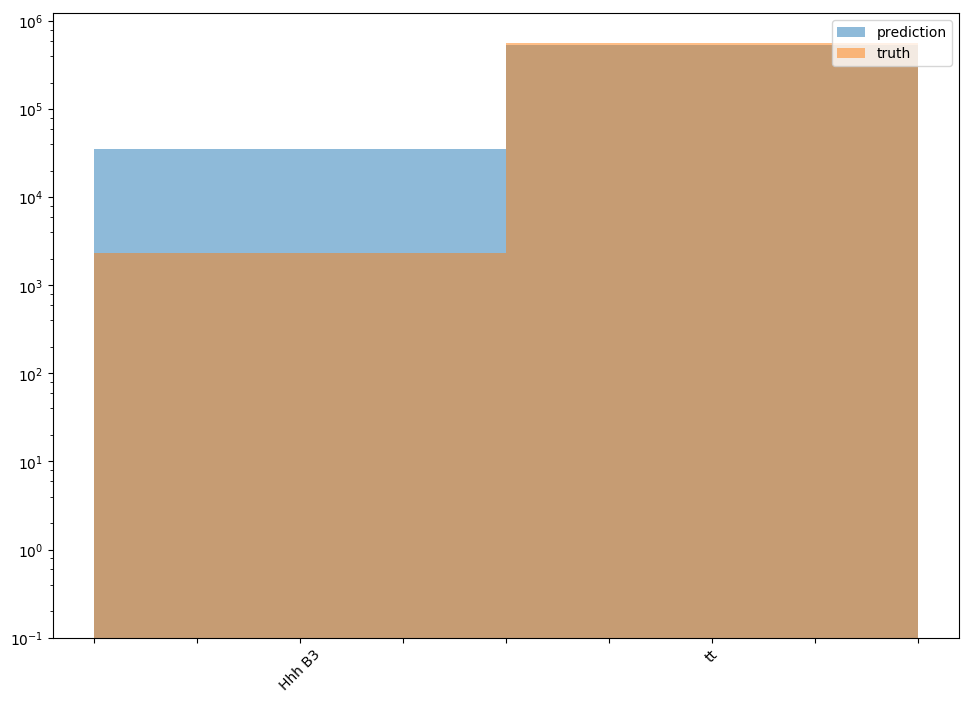

Saving weights...
Testing...
566784/569742 [============================>.] - ETA: 0s('Saving:', 'Plots_hh_tt_MLP//Performance.pdf')


In [9]:
# Load the best network (by default you return the last one, you if you save every time you have a better one you are fine loading it later)
model.load_weights('./models/tutorial-progress.h5')
print 'Saving weights...'
model.save_weights('./models/tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./models/tutorial.json', 'w').write(json_string)
print 'Testing...'
yhat = model.predict(X_test, verbose = True, batch_size = 512) # yhat is the categorization given by the DNN
#Turn them into classes
yhat_cls = np.argmax(yhat, axis=1) # Returns the indices of the maximum values along axis 1
bins = np.linspace(-0.5,1.5,3)
names = ['','','','hh','','','','tt']
fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
ax = plt.subplot()
ax.set_xticklabels(names, rotation=45)
_ = plt.hist(yhat_cls, bins=bins, histtype='stepfilled', alpha=0.5, label='prediction',log=True)#, weights=w_test)#,log=True)
_ = plt.hist(y_test, bins=bins, histtype='stepfilled', alpha=0.5, label='truth',log=True)#, weights=w_test)#,log=True)
plt.legend(loc='upper right')
print('Saving:',folder + '/Performance.pdf')
plt.savefig(folder + '/Performance.pdf')

In [10]:
print 'Signal efficiency:',     w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum()
print 'Background efficiency:', w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()

Signal efficiency: 0.951986
Background efficiency: 0.0580388
